In [1]:
import matplotlib.pyplot as plt # used to create plots
import pandas as pd # for making data frames
import numpy as np # for creation of arrays
import csv # outputs csv files

from sklearn import datasets, linear_model # linear regression model package
from sklearn.metrics import mean_squared_error, r2_score # statistics to score model 
from sklearn.model_selection import train_test_split # allows model to be tested on unseen data

import rdkit # used to import various descriptors
from rdkit import Chem
from mordred import Calculator, descriptors # another descriptors package 
from mordred import WienerIndex, ZagrebIndex, WalkCount, InformationContent

In [2]:
def linear_regression(x_data, y_data, split, show_data):
          
    '''
    
    linear_regression:
    ------------------
    
    A function that takes in a list of x-data and y-data and uses sklearn package to find the linear relationship
    between the two variables.
    
    Args:
    -----
    
    x_data: list of values for the x-axis
    y-data: list of values for the y-axis
    split: how much training data to use (e.g. 0.8 = 80% for training)
    show_data: boolean to say if information about regression should be printed (gradient, y-intercept, 
    mean square error, root mean square error and coefficient of determination)
    
    Returns:
    --------
    
    x_test: list of test data (descriptor)
    x_train: list of train data (descriptor)
    y_train: list of test data (ln(CMC))
    y_test: list of train data (ln(CMC))
    pred: list of predicted y-values using the x-test data
    pred_all: predicted values of all data using the equation y = mx + c
    
    '''
    
    indices = np.arange(len(x_data)) # list of integer values making up the indices of the data
    
    # splits the x- and y-test data randomly according to the specified ratio
    x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x_data, y_data, indices, 
                                                                             train_size = split, random_state = 42)

    x_train_format = np.array(x_train) # reformat as numpy arrays as required to reshape later
    x_test_format = np.array(x_test)

    regr = linear_model.LinearRegression() # create linear regression object
    regr.fit(x_train_format.reshape(-1,1), y_train) # train the model using the training sets   
    pred = regr.predict(x_test_format.reshape(-1,1)) # make predictions using the testing set
        
    grad = regr.coef_[0] # gradient of the predicted linear relationship 
    intercept = regr.intercept_ # y-intercept of the predicted linear relationship
    mse = mean_squared_error(y_test, pred) # mean squared error 
    rmse = np.sqrt(mean_squared_error(y_test, pred)) # root mean squared error 
    co_det = r2_score(y_test, pred) # coefficient of determination
    mae = sum(abs(y_test-pred)) / len(y_test) # mean absolute error 
    
    pred_all = [] # calculates ln(CMC) value assuming linear relationship 
    for x_val in x_data:
        pred_val = (grad * x_val) + intercept
        pred_all.append(pred_val)
    
    if show_data:  # prints data if asked for 
        print("Gradient: ", grad)
        print("Intercept: ", intercept)
        print("Root mean squared error: %.2f" % rmse)
        print("Coefficient of determination: %.2f" % co_det)
        print("Mean Absolute Error: %.2f" % mae)
        print("\n")
    
    return(x_test, x_train, y_train, y_test, pred, pred_all)

In [3]:
def linear_reg_stats_average(x_data, y_data, split):
              
    '''
    
    linear_reg_stats_average:
    --------------------------
    
    A function that takes in a list of x-data and y-data and finds the average values of the statistics: 
    coefficient of determination, root mean square error and mean absolute error using sklearn to find the 
    linear relationship.
    
    Args:
    -----
    
    x_data: list of values for the x-axis
    y-data: list of values for the y-axis
    split: test/train split
    
    Returns:
    --------
    
    rmse_av: average value of the root mean square error
    co_det_av: average value of the coefficient of determination
    mae_av: average value of the mean absolute error
    
    '''

    indices = np.arange(len(x_data)) # list of integer values making up the indices of the data
    
    rmse_list = []; co_det_list = []; mae_list = []
    rmse_total = 0; co_det_total = 0; mae_total = 0
    count = 0
    
    for rs in range(100):
        
        # splits the x- and y-test data randomly according to the specified ratio
        x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x_data, y_data, indices, 
                                                                                 train_size = split, 
                                                                                 random_state = rs)

        x_train_format = np.array(x_train) # reformat as numpy arrays as required to reshape later
        x_test_format = np.array(x_test)

        regr = linear_model.LinearRegression() # create linear regression object
        regr.fit(x_train_format.reshape(-1,1), y_train) # train the model using the training sets                                
        pred = regr.predict(x_test_format.reshape(-1,1))  # make predictions using the testing set
        
        grad = regr.coef_[0] # gradient of the predicted linear relationship 
        intercept = regr.intercept_ # y-intercept of the predicted linear relationship
        
        y_test_cmc = ln_cmc_to_cmc(y_test) # converts measured and predicted ln(CMC) back to CMC
        pred_cmc = ln_cmc_to_cmc(pred)
        
        mse = mean_squared_error(y_test_cmc, pred_cmc) # mean squared error of results
        rmse = np.sqrt(mean_squared_error(y_test_cmc, pred_cmc)) # root mean squared error 
        co_det = r2_score(y_test_cmc, pred_cmc) # coefficient of determination 
        mae = sum(abs(y_test_cmc-pred_cmc)) / len(y_test_cmc) # mean absolute error 

        if co_det < 0.0: # consider all less than 0 as no correlation
            co_det = 0.0
        
        rmse_list.append(rmse); co_det_list.append(co_det); mae_list.append(mae)
        
        rmse_total += rmse # adds up the statistics values
        co_det_total += co_det
        mae_total += mae
        count += 1
        
    rmse_av = rmse_total / count # finds the average by dividing by the number of loops
    co_det_av = co_det_total / count
    mae_av = mae_total / count
    
    print("RMSE Mean: ", round(rmse_av, 2))
    print("Coeff of Det Mean: ", round(co_det_av, 2))
    print("MAE Mean: ", round(mae_av, 2))
    print("\n")
    print("RMSE Median: ", round(np.percentile(rmse_list, 50), 2))
    print("Coeff of Det Median: ", round(np.percentile(co_det_list, 50), 2))
    print("MAE Median: ", round(np.percentile(mae_list, 50), 2))
    print("\n")
    
    return(rmse_av, co_det_av, mae_av)

In [4]:
def ln_cmc_to_cmc(ln_cmc):
              
    '''
    
    ln_cmc_to_cmc:
    --------------
    
    A function that takes in the predicted ln(CMC) values and converts them to CMC values
    
    Args:
    -----
    
    ln_cmc: list of predicted ln(CMC) values
    
    Returns:
    --------
    
    acc_cmc: numpy array of CMC values
    
    '''
          
    cmc_list = []
    
    for val in ln_cmc:
        cmc = np.exp(val) # converts to CMC using the exponential 
        cmc_list.append(cmc)
        
    arr_cmc = np.array(cmc_list)
        
    return(arr_cmc)

In [5]:
def test_train_plotter(x_test, x_train, x_all, y_test, y_train, pred, x_label, file_name):
                  
    '''
    
    test_train_plotter:
    ------------------
    
    A function that plots the test and training data as well as the line of best fit calculated from the x-data
    using the gradient and y-intercept
    
    Args:
    -----
    
    x_test: list of x-values used to test
    x_train: list of x-values used to train
    y_test: list of y-values used to test
    y_train: list of y-values used to train
    pred: predicted data based on results of linear regression
    x_label: label for the x-axis
    file_name: name to save figure
    
    Returns:
    --------
    
    plot showing the test and training data and predicted line
    
    '''
    
    f = plt.figure() # sets figure size 
    f.set_figwidth(4.5)
    f.set_figheight(3)
    
    plt.scatter(x_test, y_test, s = 10, color = "green", label = "test") # plots test data
    plt.scatter(x_train, y_train, s = 10, color = "orange", label = "train") # plots training data 
    
    plt.plot(x_all, pred, color = "blue", linewidth = 0.5) # plots predicted line
  
    plt.legend(fontsize = "large")
    plt.ylabel("ln(CMC / mM)", fontsize = 12)
    plt.xlabel(x_label, fontsize = 12)

    #plt.savefig("Plots/" + file_name, dpi = 500, bbox_inches = "tight")
    plt.show()
    
    return

In [6]:
cmc_data = pd.read_csv(open("Submit_Data/output_smiles.csv"), 
                       delimiter = (","))  
# reads in data about the critical micelle concentration, values are separated by a comma
    
func_group = []; chain = []; smiles = []; smiles_head = []; smiles_tail = []; carbon_length = []; 
ethoxy_length = []; ph_exists = []; counter_ion = []; cmc_vals = []; ln_cmc = []

for ind, row in cmc_data.iterrows(): # reads in the rows of the data 
    
    func_group_i = row["Surfactant"]       # head group info 
    chain_i = row["Chain"]                 # chain length
    smiles_i = row["Smiles"]               # smiles string
    smiles_head_i = row["Head Smiles"]     # smiles string of head group only
    smiles_tail_i = row["Tail Smiles"]     # smiles string of head group only
    carbon_length_i = row["Carbon Length"] # carbon chain length
    ethoxy_length_i = row["Ethoxy Length"] # ethoxylate group length
    counter_ion_i = row["Counter Ion"]     # finds counter ion
    cmc_i = row["CMC / mM"]                # finds CMC data
    
    func_group.append(func_group_i)   # adds the data to separate lists  
    chain.append(chain_i); smiles.append(smiles_i); smiles_head.append(smiles_head_i)
    smiles_tail.append(smiles_tail_i); carbon_length.append(carbon_length_i); ethoxy_length.append(ethoxy_length_i)
    counter_ion.append(counter_ion_i); cmc_vals.append(cmc_i); ln_cmc.append(np.log(cmc_i))

In [7]:
mol_list = [rdkit.Chem.MolFromSmiles(smiles_str) for smiles_str in smiles]
# converts smile string into an RDKit mol object for each smiles string and puts it into a new list

In [8]:
mol_weight = [rdkit.Chem.Descriptors.ExactMolWt(elem) for elem in mol_list]
# uses the function to calculate the molecular weight of each of the mol objects and puts them into a new list

In [9]:
val_elec = [rdkit.Chem.Descriptors.NumValenceElectrons(elem) for elem in mol_list]
# does the same for a variety of descriptors

In [10]:
max_par_charge = [rdkit.Chem.Descriptors.MaxPartialCharge(elem) for elem in mol_list]

In [11]:
min_par_charge = [rdkit.Chem.Descriptors.MinPartialCharge(elem) for elem in mol_list]

In [12]:
max_abs_par_charge = [rdkit.Chem.Descriptors.MaxAbsPartialCharge(elem) for elem in mol_list]

In [13]:
min_abs_par_charge = [rdkit.Chem.Descriptors.MinAbsPartialCharge(elem) for elem in mol_list]

In [14]:
logp = [rdkit.Chem.Crippen.MolLogP(elem) for elem in mol_list]

In [15]:
hbond_accept = [rdkit.Chem.Lipinski.NumHAcceptors(elem) for elem in mol_list]

In [16]:
aromatic_rings = [rdkit.Chem.Lipinski.NumAromaticRings(elem) for elem in mol_list]

In [17]:
bertzct = [rdkit.Chem.GraphDescriptors.BertzCT(elem) for elem in mol_list]

In [18]:
chi0 = [rdkit.Chem.GraphDescriptors.Chi0(elem) for elem in mol_list]

In [19]:
chi1 = [rdkit.Chem.GraphDescriptors.Chi1(elem) for elem in mol_list]

In [20]:
peoe_vsa6 = [rdkit.Chem.MolSurf.PEOE_VSA6(elem) for elem in mol_list]

In [21]:
labute_asa = [rdkit.Chem.rdMolDescriptors.CalcLabuteASA(elem) for elem in mol_list]

In [22]:
molmr = [rdkit.Chem.Crippen.MolMR(elem) for elem in mol_list]

In [23]:
estate_vsa9 = [rdkit.Chem.EState.EState_VSA.EState_VSA9(elem) for elem in mol_list]

In [24]:
wiener_index_calc = WienerIndex.WienerIndex()
wiener_index = [wiener_index_calc(elem) for elem in mol_list]

In [25]:
zagreb_index1_calc = ZagrebIndex.ZagrebIndex(version = 1)            
zagreb_index2_calc = ZagrebIndex.ZagrebIndex(version = 2)           

zagreb_index1 = [zagreb_index1_calc(elem) for elem in mol_list]                              
zagreb_index2 = [zagreb_index2_calc(elem) for elem in mol_list]   

In [26]:
walk_count_calc = WalkCount.WalkCount()
walk_count = [walk_count_calc(elem) for elem in mol_list]

In [27]:
total_ic_calc = InformationContent.TotalIC()
total_ic = [total_ic_calc(elem) for elem in mol_list]

In [28]:
plot_data = pd.DataFrame(func_group, columns = ["func_group"])
plot_data["carbon_len"] = carbon_length
plot_data["CMC"] = cmc_vals
plot_data["ln_cmc"] = ln_cmc
plot_data["MW"] = mol_weight
plot_data["NVE"] = val_elec
plot_data["logP"] = logp

In [29]:
# creates headers for the new outputted csv file
header = ["func_group", "chain", "smiles", "head_smiles", "tail_smiles", "carbon_len", "ethoxy_len", 
          "aromatic_rings", "counter_ion", "CMC", "MW", "NVE", "logP", "chi0", "bertzct", "chi1", "peoe_vsa6",
         "labute_asa", "molmr", "wiener_index", "zagreb_index1", "zagreb_index2", "walk_count", "total_ic"] 

# creates a new csv file with additional information
with open("Submit_Data/output_descriptors.csv", "w") as file:
    writer = csv.writer(file) # creates a new file
    writer.writerow(header)   # adds the headers as the first row in the file
                   
    # finds a row of the new data to be added to the csv file using the index
    for ind, func_group in enumerate(func_group):
        current_row = [func_group, chain[ind], smiles[ind], smiles_head[ind], smiles_tail[ind], carbon_length[ind],
                       ethoxy_length[ind], aromatic_rings[ind], counter_ion[ind], cmc_vals[ind], mol_weight[ind], 
                       val_elec[ind], logp[ind], chi0[ind], bertzct[ind], chi1[ind], peoe_vsa6[ind], 
                       labute_asa[ind], molmr[ind], wiener_index[ind], zagreb_index1[ind], zagreb_index2[ind], 
                       walk_count[ind], total_ic[ind]]
                              
        writer.writerow(current_row) # writes the new row to the csv file

***Number of carbon atoms in tail***

*Average statistics results using 70% train data*

In [30]:
rmse_av_c, co_det_av_c, mae_av_c = linear_reg_stats_average(carbon_length, ln_cmc, 0.7)

RMSE Mean:  68.19
Coeff of Det Mean:  0.0
MAE Mean:  27.12


RMSE Median:  69.64
Coeff of Det Median:  0.0
MAE Median:  25.9




*Splits the test and train data in a ratio of 30:70*

Gradient:  -0.4209517387770317
Intercept:  5.558576350535257
Root mean squared error: 2.42
Coefficient of determination: 0.32
Mean Absolute Error: 2.06




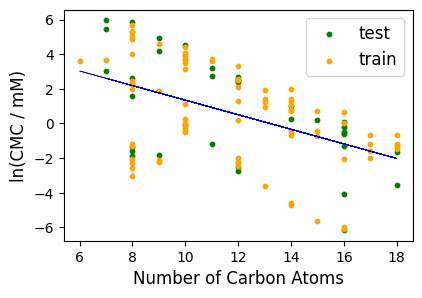

In [31]:
c_xtest, c_xtrain, c_ytrain, c_ytest, c_ypred, c_ypredall = linear_regression(carbon_length, ln_cmc, 0.7, True)

test_train_plotter(c_xtest, c_xtrain, carbon_length, c_ytest, c_ytrain, c_ypredall, "Number of Carbon Atoms",
                  "cLen_linreg_all.png")

***Molecular weight***

In [32]:
rmse_av_MW, co_det_av_MW, mae_av_MW = linear_reg_stats_average(mol_weight, ln_cmc, 0.7)

RMSE Mean:  66.41
Coeff of Det Mean:  0.03
MAE Mean:  25.52


RMSE Median:  67.95
Coeff of Det Median:  0.0
MAE Median:  24.19




Gradient:  -0.013538373741890269
Intercept:  5.151130675445233
Root mean squared error: 2.13
Coefficient of determination: 0.47
Mean Absolute Error: 1.67




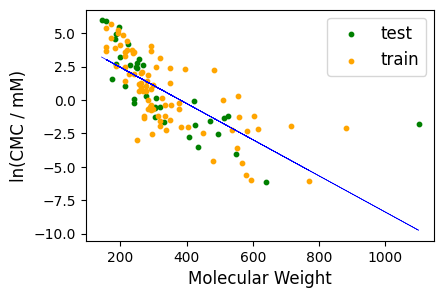

In [33]:
MW_xtest, MW_xtrain, MW_ytrain, MW_ytest, MW_ypred, MW_ypredall = linear_regression(mol_weight, ln_cmc, 0.7, True)

test_train_plotter(MW_xtest, MW_xtrain, mol_weight, MW_ytest, MW_ytrain, MW_ypredall, "Molecular Weight", 
                   "MW_linreg_all.png")

*Comparing predictions of ln(CMC) and CMC*

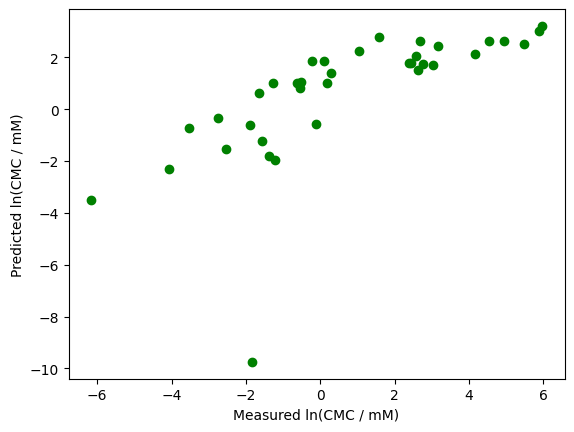

In [34]:
plt.scatter(MW_ytest, MW_ypred, color = "green")
plt.xlabel("Measured ln(CMC / mM)")
plt.ylabel("Predicted ln(CMC / mM)")
plt.show()

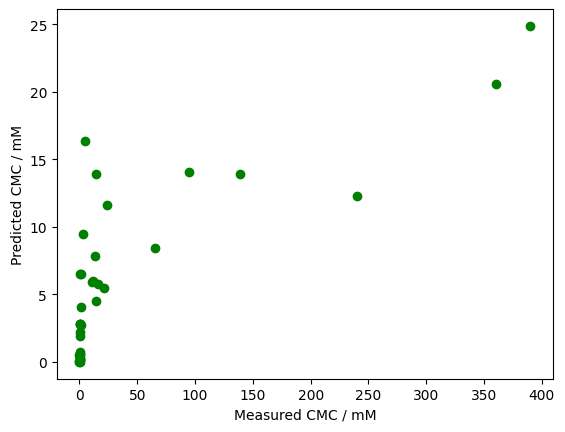

In [35]:
MW_ytest_cmc = ln_cmc_to_cmc(MW_ytest)
MW_ypred_cmc = ln_cmc_to_cmc(MW_ypred)

plt.scatter(MW_ytest_cmc, MW_ypred_cmc, color = "green")
plt.xlabel("Measured CMC / mM")
plt.ylabel("Predicted CMC / mM")
plt.show()

***Number of valence electrons***

In [36]:
rmse_av_NVE, co_det_av_NVE, mae_av_NVE = linear_reg_stats_average(val_elec, ln_cmc, 0.7)

RMSE Mean:  66.43
Coeff of Det Mean:  0.03
MAE Mean:  25.49


RMSE Median:  68.08
Coeff of Det Median:  0.0
MAE Median:  24.18




Gradient:  -0.03285030031597293
Intercept:  5.140409677168757
Root mean squared error: 2.10
Coefficient of determination: 0.48
Mean Absolute Error: 1.65




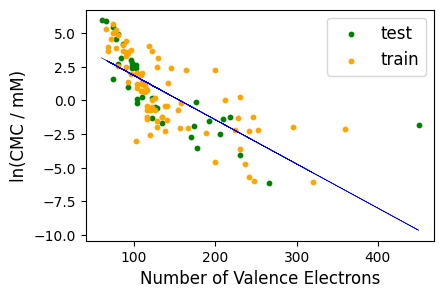

In [37]:
NVE_xtest, NVE_xtrain, NVE_ytrain, NVE_ytest, NVE_ypred, NVE_ypredall = linear_regression(val_elec, ln_cmc, 0.7, 
                                                                                          True)

test_train_plotter(NVE_xtest, NVE_xtrain, val_elec, NVE_ytest, NVE_ytrain, NVE_ypredall, 
                   "Number of Valence Electrons", "NVE_linreg_all.png")

***Max partial charge***

Gradient:  4.155328439528128
Intercept:  0.14030019173076264
Root mean squared error: 2.96
Coefficient of determination: -0.02
Mean Absolute Error: 2.50




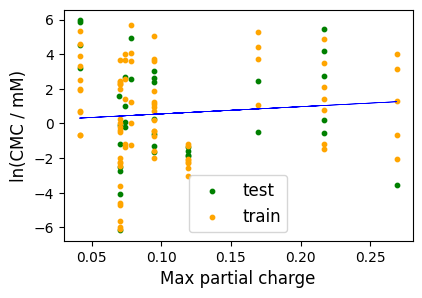

In [38]:
PC1_xtest, PC1_xtrain, PC1_ytrain, PC1_ytest, PC1_ypred, PC1_ypredall = linear_regression(max_par_charge, ln_cmc, 
                                                                                          0.7, True)

test_train_plotter(PC1_xtest, PC1_xtrain, max_par_charge, PC1_ytest, PC1_ytrain, PC1_ypredall, 
                   "Max partial charge", "maxPC_linreg_all.png")

***Absolute max partial charge***

Gradient:  0.5566635039424043
Intercept:  0.3045650717046979
Root mean squared error: 2.91
Coefficient of determination: 0.01
Mean Absolute Error: 2.46




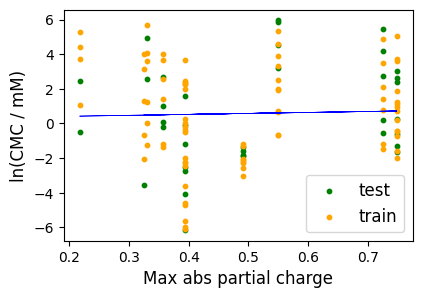

In [39]:
PC2_xtest, PC2_xtrain, PC2_ytrain, PC2_ytest, PC2_ypred, PC2_ypredall = linear_regression(max_abs_par_charge, 
                                                                                          ln_cmc, 0.7, True)

test_train_plotter(PC2_xtest, PC2_xtrain, max_abs_par_charge, PC2_ytest, PC2_ytrain, PC2_ypredall, 
                   "Max abs partial charge", "maxabsPC_linreg_all.png")

***Min partial charge***

Gradient:  -0.5566635039424043
Intercept:  0.3045650717046979
Root mean squared error: 2.91
Coefficient of determination: 0.01
Mean Absolute Error: 2.46




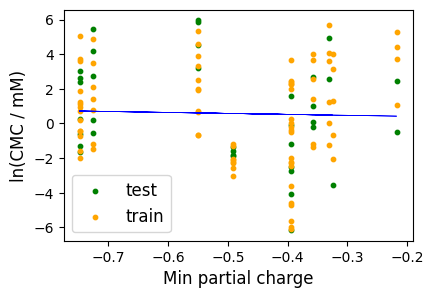

In [40]:
PC3_xtest, PC3_xtrain, PC3_ytrain, PC3_ytest, PC3_ypred, PC3_ypredall = linear_regression(min_par_charge, ln_cmc, 
                                                                                          0.7, True)

test_train_plotter(PC3_xtest, PC3_xtrain, min_par_charge, PC3_ytest, PC3_ytrain, PC3_ypredall, 
                   "Min partial charge", "minPC_linreg_all.png")

***Min abs partial charge***

Gradient:  4.155328439528128
Intercept:  0.14030019173076264
Root mean squared error: 2.96
Coefficient of determination: -0.02
Mean Absolute Error: 2.50




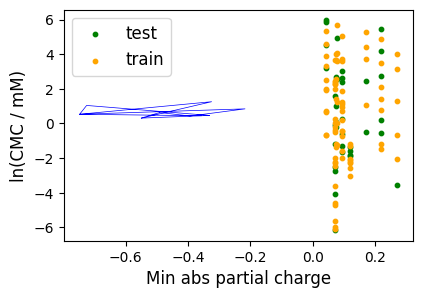

In [41]:
PC3_xtest, PC3_xtrain, PC3_ytrain, PC3_ytest, PC3_ypred, PC3_ypredall = linear_regression(min_abs_par_charge, 
                                                                                          ln_cmc, 0.7, True)

test_train_plotter(PC3_xtest, PC3_xtrain, min_par_charge, PC3_ytest, PC3_ytrain, PC3_ypredall, 
                   "Min abs partial charge", "minabsPC_linreg_all.png")

***LogP***

In [42]:
rmse_av_logp, co_det_av_logp, mae_av_logp = linear_reg_stats_average(logp, ln_cmc, 0.7)

RMSE Mean:  58.01
Coeff of Det Mean:  0.21
MAE Mean:  22.67


RMSE Median:  54.9
Coeff of Det Median:  0.21
MAE Median:  20.64




Gradient:  -1.3232487287406116
Intercept:  5.94067261248503
Root mean squared error: 1.91
Coefficient of determination: 0.57
Mean Absolute Error: 1.53




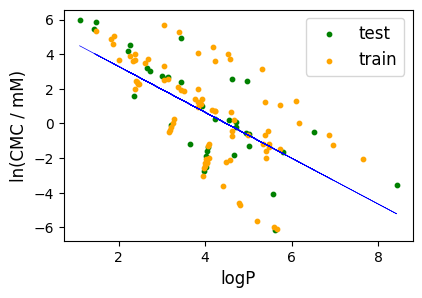

In [43]:
logp_xtest, logp_xtrain, logp_ytrain, logp_ytest, logp_ypred, logp_ypredall = linear_regression(logp, ln_cmc, 0.7, 
                                                                                                True)

test_train_plotter(logp_xtest, logp_xtrain, logp, logp_ytest, logp_ytrain, logp_ypredall, 
                   "logP", "logP_linreg_all.png")

***H Bond acceptors***

Gradient:  -0.44003011535607406
Intercept:  2.3284133138567125
Root mean squared error: 2.56
Coefficient of determination: 0.24
Mean Absolute Error: 2.09




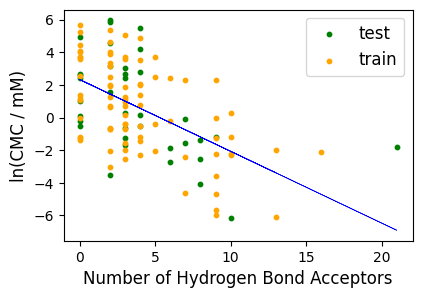

In [44]:
HB_xtest, HB_xtrain, HB_ytrain, HB_ytest, HB_ypred, HB_ypredall = linear_regression(hbond_accept, ln_cmc, 0.7, 
                                                                                    True)

test_train_plotter(HB_xtest, HB_xtrain, hbond_accept, HB_ytest, HB_ytrain, HB_ypredall, 
                   "Number of Hydrogen Bond Acceptors", "HB_linreg_all.png")

***Chi0***

In [45]:
rmse_av_chi0, co_det_av_chi0, mae_av_chi0 = linear_reg_stats_average(chi0, ln_cmc, 0.7)

RMSE Mean:  66.47
Coeff of Det Mean:  0.03
MAE Mean:  25.52


RMSE Median:  68.15
Coeff of Det Median:  0.0
MAE Median:  24.21




Gradient:  -0.27947567310906907
Intercept:  5.359502099205617
Root mean squared error: 2.12
Coefficient of determination: 0.48
Mean Absolute Error: 1.66




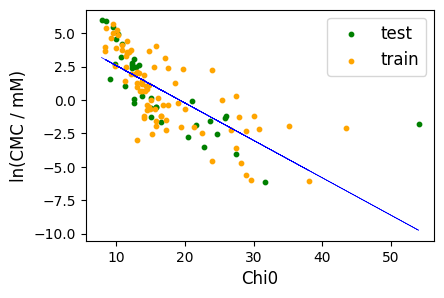

In [46]:
C0_xtest, C0_xtrain, C0_ytrain, C0_ytest, C0_ypred, C0_ypredall = linear_regression(chi0, ln_cmc, 0.7, True)

test_train_plotter(C0_xtest, C0_xtrain, chi0, C0_ytest, C0_ytrain, C0_ypredall, "Chi0", "chi0_linreg_all.png")

***BertzCT***

In [47]:
rmse_av_BC, co_det_av_BC, mae_av_BC = linear_reg_stats_average(bertzct, ln_cmc, 0.7)

RMSE Mean:  68.99
Coeff of Det Mean:  0.0
MAE Mean:  26.99


RMSE Median:  70.65
Coeff of Det Median:  0.0
MAE Median:  25.89




Gradient:  -0.009183855859875849
Intercept:  3.216911746101915
Root mean squared error: 2.51
Coefficient of determination: 0.27
Mean Absolute Error: 2.06




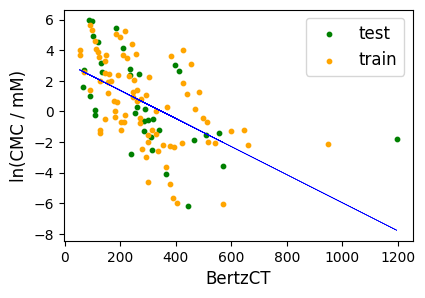

In [48]:
BCT_xtest, BCT_xtrain, BCT_ytrain, BCT_ytest, BCT_ypred, BCT_ypredall = linear_regression(bertzct, ln_cmc, 0.7, 
                                                                                          True)

test_train_plotter(BCT_xtest, BCT_xtrain, bertzct, BCT_ytest, BCT_ytrain, BCT_ypredall, "BertzCT", 
                   "bertzct_linreg_all.png")

***Chi1***

In [49]:
rmse_av_chi1, co_det_av_chi1, mae_av_chi1 = linear_reg_stats_average(chi1, ln_cmc, 0.7)

RMSE Mean:  66.49
Coeff of Det Mean:  0.03
MAE Mean:  25.55


RMSE Median:  68.12
Coeff of Det Median:  0.0
MAE Median:  24.37




Gradient:  -0.38512356590041585
Intercept:  4.955038169734263
Root mean squared error: 2.12
Coefficient of determination: 0.48
Mean Absolute Error: 1.66




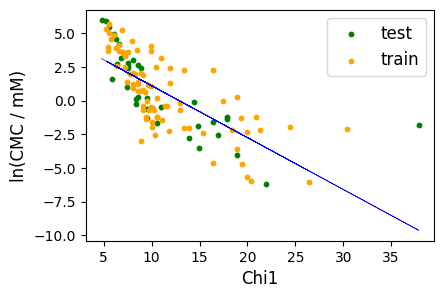

In [50]:
C1_xtest, C1_xtrain, C1_ytrain, C1_ytest, C1_ypred, C1_ypredall = linear_regression(chi1, ln_cmc, 0.7, True)

test_train_plotter(C1_xtest, C1_xtrain, chi1, C1_ytest, C1_ytrain, C1_ypredall, "Chi1", "chi1_linreg_all.png")

***PEOE-VSA6***

In [51]:
rmse_av_PV, co_det_av_PV, mae_av_PV = linear_reg_stats_average(peoe_vsa6, ln_cmc, 0.7)

RMSE Mean:  64.53
Coeff of Det Mean:  0.07
MAE Mean:  25.73


RMSE Median:  65.45
Coeff of Det Median:  0.04
MAE Median:  24.54




Gradient:  -0.08506669679352245
Intercept:  6.0661027637914975
Root mean squared error: 2.19
Coefficient of determination: 0.44
Mean Absolute Error: 1.97




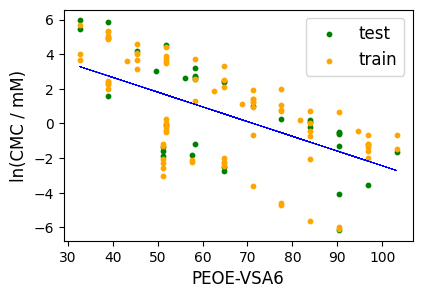

In [52]:
PV_xtest, PV_xtrain, PV_ytrain, PV_ytest, PV_ypred, PV_ypredall = linear_regression(peoe_vsa6, ln_cmc, 0.7, True)

test_train_plotter(PV_xtest, PV_xtrain, peoe_vsa6, PV_ytest, PV_ytrain, PV_ypredall, "PEOE-VSA6", 
                   "peoe_vsa6_linreg_all.png")

***Labute-ASA***

In [53]:
rmse_av_LA, co_det_av_LA, mae_av_LA = linear_reg_stats_average(labute_asa, ln_cmc, 0.7)

RMSE Mean:  66.06
Coeff of Det Mean:  0.03
MAE Mean:  25.32


RMSE Median:  67.59
Coeff of Det Median:  0.0
MAE Median:  24.03




Gradient:  -0.03312103730251945
Intercept:  5.343739125351776
Root mean squared error: 2.09
Coefficient of determination: 0.49
Mean Absolute Error: 1.63




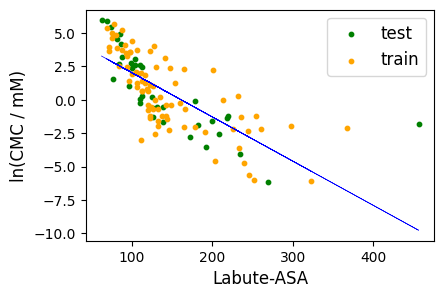

In [54]:
LA_xtest, LA_xtrain, LA_ytrain, LA_ytest, LA_ypred, LA_ypredall = linear_regression(labute_asa, ln_cmc, 0.7, True)

test_train_plotter(LA_xtest, LA_xtrain, labute_asa, LA_ytest, LA_ytrain, LA_ypredall, "Labute-ASA", 
                   "labute_asa_linreg_all.png")

***MolMR***

In [55]:
rmse_av_molmr, co_det_av_molmr, mae_av_molmr = linear_reg_stats_average(molmr, ln_cmc, 0.7)

RMSE Mean:  64.51
Coeff of Det Mean:  0.06
MAE Mean:  24.58


RMSE Median:  65.49
Coeff of Det Median:  0.03
MAE Median:  23.09




Gradient:  -0.054306068294501166
Intercept:  5.745796819671486
Root mean squared error: 2.00
Coefficient of determination: 0.53
Mean Absolute Error: 1.52




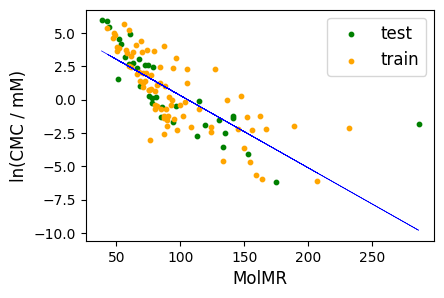

In [56]:
MM_xtest, MM_xtrain, MM_ytrain, MM_ytest, MM_ypred, MM_ypredall = linear_regression(molmr, ln_cmc, 0.7, True)

test_train_plotter(MM_xtest, MM_xtrain, molmr, MM_ytest, MM_ytrain, MM_ypredall, "MolMR", "molmr_linreg_all.png")

***Estate-VSA9***

In [57]:
rmse_av_EV, co_det_av_EV, mae_av_EV = linear_reg_stats_average(estate_vsa9, ln_cmc, 0.7)

RMSE Mean:  69.77
Coeff of Det Mean:  0.0
MAE Mean:  27.68


RMSE Median:  71.33
Coeff of Det Median:  0.0
MAE Median:  26.46




Gradient:  -0.07901550299486226
Intercept:  1.6117941214293674
Root mean squared error: 2.42
Coefficient of determination: 0.32
Mean Absolute Error: 2.03




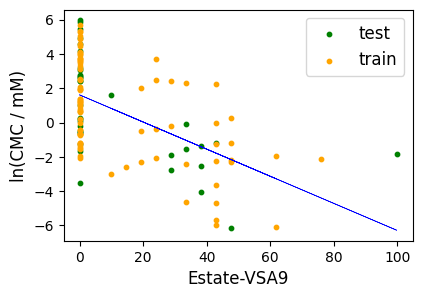

In [58]:
EV_xtest, EV_xtrain, EV_ytrain, EV_ytest, EV_ypred, EV_ypredall = linear_regression(estate_vsa9, ln_cmc, 0.7, True)

test_train_plotter(EV_xtest, EV_xtrain, estate_vsa9, EV_ytest, EV_ytrain, EV_ypredall, "Estate-VSA9", 
                   "estate_vsa9_linreg_all.png")

***Wiener Index***

In [59]:
rmse_av_WI, co_det_av_WI, mae_av_WI = linear_reg_stats_average(wiener_index, ln_cmc, 0.7)

RMSE Mean:  70.23
Coeff of Det Mean:  0.0
MAE Mean:  27.58


RMSE Median:  71.89
Coeff of Det Median:  0.0
MAE Median:  26.72




Gradient:  -0.0002671972228463625
Intercept:  1.504550855172122
Root mean squared error: 3.52
Coefficient of determination: -0.44
Mean Absolute Error: 2.42




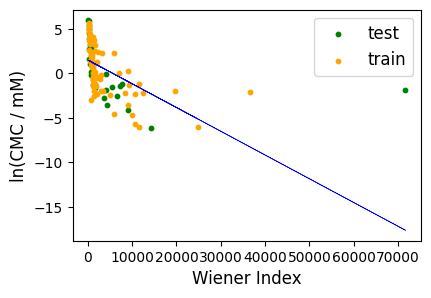

In [60]:
WI_xtest, WI_xtrain, WI_ytrain, WI_ytest, WI_ypred, WI_ypredall = linear_regression(wiener_index, ln_cmc, 0.7, 
                                                                                    True)

test_train_plotter(WI_xtest, WI_xtrain, wiener_index, WI_ytest, WI_ytrain, WI_ypredall, "Wiener Index", 
                   "wiener_index_linreg_all.png")

***Zagreb Index 1***

In [61]:
rmse_av_ZI1, co_det_av_ZI1, mae_av_ZI1 = linear_reg_stats_average(zagreb_index1, ln_cmc, 0.7)

RMSE Mean:  66.48
Coeff of Det Mean:  0.03
MAE Mean:  25.62


RMSE Median:  67.9
Coeff of Det Median:  0.0
MAE Median:  24.28




Gradient:  -0.04785177030944824
Intercept:  4.9872237444846625
Root mean squared error: 2.16
Coefficient of determination: 0.46
Mean Absolute Error: 1.70




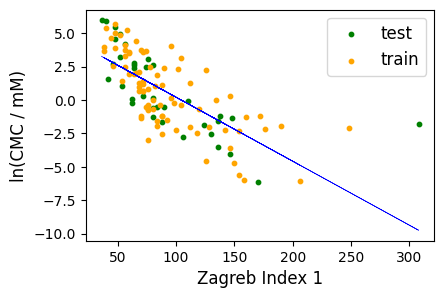

In [62]:
ZI1_xtest, ZI1_xtrain, ZI1_ytrain, ZI1_ytest, ZI1_ypred, ZI1_ypredall = linear_regression(zagreb_index1, ln_cmc, 
                                                                                          0.7, True)

test_train_plotter(ZI1_xtest, ZI1_xtrain, zagreb_index1, ZI1_ytest, ZI1_ytrain, ZI1_ypredall, "Zagreb Index 1", 
                   "zagreb_index1_linreg_all.png")

***Zagreb Index 2***

In [63]:
rmse_av_ZI2, co_det_av_ZI2, mae_av_ZI2 = linear_reg_stats_average(zagreb_index2, ln_cmc, 0.7)

RMSE Mean:  66.61
Coeff of Det Mean:  0.02
MAE Mean:  25.71


RMSE Median:  68.01
Coeff of Det Median:  0.0
MAE Median:  24.43




Gradient:  -0.046050290921120826
Intercept:  4.80161233617168
Root mean squared error: 2.17
Coefficient of determination: 0.45
Mean Absolute Error: 1.71




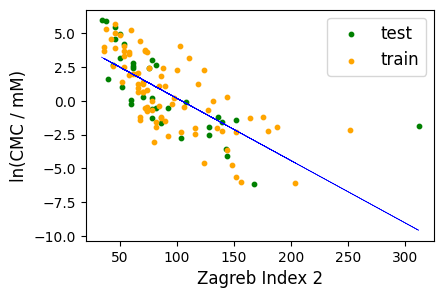

In [64]:
ZI2_xtest, ZI2_xtrain, ZI2_ytrain, ZI2_ytest, ZI2_ypred, ZI2_ypredall = linear_regression(zagreb_index2, ln_cmc, 
                                                                                          0.7, True)

test_train_plotter(ZI2_xtest, ZI2_xtrain, zagreb_index2, ZI2_ytest, ZI2_ytrain, ZI2_ypredall, "Zagreb Index 2", 
                   "zagreb_index2_linreg_all.png")

***Walk Count***

In [65]:
rmse_av_WC, co_det_av_WC, mae_av_WC = linear_reg_stats_average(walk_count, ln_cmc, 0.7)

RMSE Mean:  66.46
Coeff of Det Mean:  0.03
MAE Mean:  25.56


RMSE Median:  68.0
Coeff of Det Median:  0.0
MAE Median:  24.33




Gradient:  -0.1925066753383466
Intercept:  4.910425489383168
Root mean squared error: 2.13
Coefficient of determination: 0.47
Mean Absolute Error: 1.67




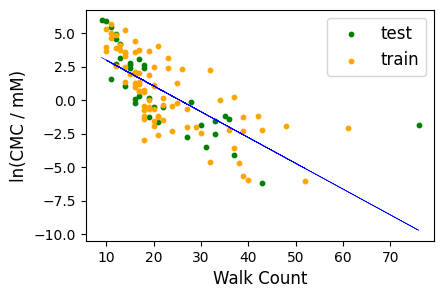

In [66]:
WC_xtest, WC_xtrain, WC_ytrain, WC_ytest, WC_ypred, WC_ypredall = linear_regression(walk_count, ln_cmc, 0.7, True)

test_train_plotter(WC_xtest, WC_xtrain, walk_count, WC_ytest, WC_ytrain, WC_ypredall, "Walk Count", 
                   "walk_count_linreg_all.png")

***Total IC***

In [67]:
rmse_av_TI, co_det_av_TI, mae_av_TI = linear_reg_stats_average(total_ic, ln_cmc, 0.7)

RMSE Mean:  66.44
Coeff of Det Mean:  0.03
MAE Mean:  25.54


RMSE Median:  68.03
Coeff of Det Median:  0.0
MAE Median:  24.1




Gradient:  -0.05994887652858852
Intercept:  5.065930695076494
Root mean squared error: 2.09
Coefficient of determination: 0.49
Mean Absolute Error: 1.64




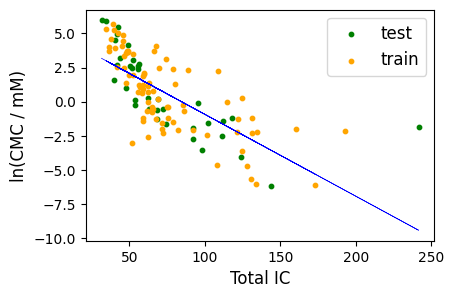

In [68]:
TI_xtest, TI_xtrain, TI_ytrain, TI_ytest, TI_ypred, TI_ypredall = linear_regression(total_ic, ln_cmc, 0.7, True)

test_train_plotter(TI_xtest, TI_xtrain, total_ic, TI_ytest, TI_ytrain, TI_ypredall, "Total IC", 
                   "total_ic_linreg_all.png")